# ตั้งค่า และลงlibrary

## Install library

In [ ]:
# สำหรับคนที่ยังไม่ได้ลงไลบรารี่ fastbook ให้ uncomment บรรทัด !pip install
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 7.6 MB/s 
     |████████████████████████████████| 197 kB 71.7 MB/s 
     |████████████████████████████████| 1.2 MB 54.4 MB/s 
     |████████████████████████████████| 346 kB 78.1 MB/s 
     |████████████████████████████████| 4.2 MB 54.4 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 86 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 58.6 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 140 kB 73.1 MB/s 
     |████████████████████████████████| 212 kB 55.5 MB/s 
     |████████████████████████████████| 596 kB 12.1 MB/s 
     |████████████████████████████████| 127 kB 68.6 MB/s 
     |████████████████████████████████| 144 kB 70.2 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 271 kB 77.1 MB/s 
     |████████████████████████████████| 112 kB 75.4 MB/s 
     |█████████████████

In [ ]:
from fastbook import *

# จัดการข้อมูลเพื่อใช้ในการเทรนโมเดล

## Split data

In [ ]:
import splitfolders

input_folder = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/generated_image"

In [ ]:
#เปิดโฟล์เดอร์ที่ต้องการแบ่ง
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication


In [ ]:
splitfolders.ratio(input_folder, output="DataGen", 
                   seed=42, ratio=(.85, .0, .15), 
                   group_prefix=None) 
#แบ่ง train val กับ test 0.85:0:0.15

Copying files: 3606 files [00:30, 118.46 files/s]


## Prepare Dataloders

In [ ]:
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.4, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
)

In [ ]:
#ตำแหน่งของไฟล์ที่จะเทรน
PathTrain = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/back_front_classification"

In [ ]:
#ทำdataloader
dls = fields.dataloaders(PathTrain)

In [ ]:
#label
dls.vocab

['back', 'front']

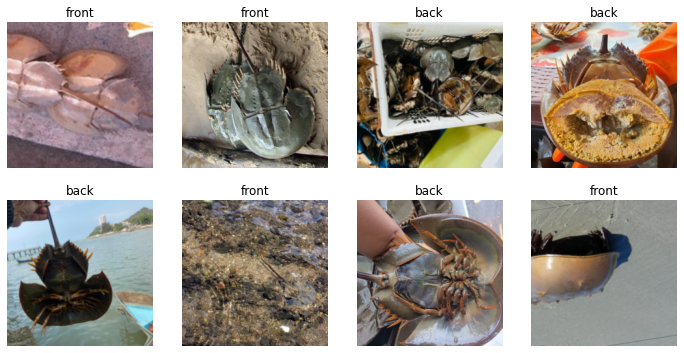

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

# **เทรน model**
ในที่นี้ผมใช้ backbone 5 อย่าง คือ 
1. VGG16
2. resneXt50
2. densenet201
3. VGG19
4. Squeezenet1_1
5. alexnet

## VGG16

In [ ]:
#load backbone
learner_VGG16 = cnn_learner(dls, models.vgg16_bn, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0020892962347716093)

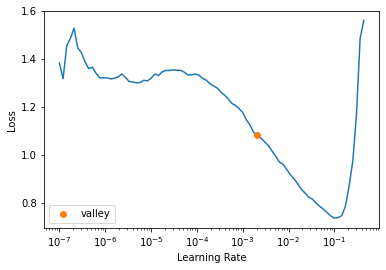

In [ ]:
# หา learning rate ที่เหมาะสม
learner_VGG16.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
#เทรนโมเดล 20 รอบ
learner_VGG16.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0020892962347716093)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.195112,1.738695,0.655556,0.344444,0.157143,1.000000,0.085271,00:29


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.669647,0.879155,0.416667,0.583333,0.590164,1.000000,0.418605,00:16
1,0.726040,0.446626,0.161111,0.838889,0.873362,1.000000,0.775194,00:16
2,0.641606,0.361664,0.100000,0.900000,0.925620,0.991150,0.868217,00:15
3,0.580267,0.421303,0.066667,0.933333,0.951220,1.000000,0.906977,00:16
4,0.530964,0.470795,0.061111,0.938889,0.955823,0.991667,0.922481,00:16
5,0.476244,0.446520,0.077778,0.922222,0.944882,0.960000,0.930233,00:16
6,0.433803,0.583243,0.077778,0.922222,0.944444,0.967480,0.922481,00:16
7,0.391454,0.770813,0.072222,0.927778,0.947791,0.983333,0.914729,00:16
8,0.357191,0.773303,0.072222,0.927778,0.948207,0.975410,0.922481,00:16
9,0.324374,0.709677,0.077778,0.922222,0.944882,0.960000,0.930233,00:16


In [ ]:
#save models
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_back_front
learner_VGG16.export("VGG16_fastai.pkl")

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_back_front


## resnext50

In [ ]:
from torchvision.models.resnet import resnext50_32x4d
#load backbone
learner_resnext = cnn_learner(dls, resnext50_32x4d, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

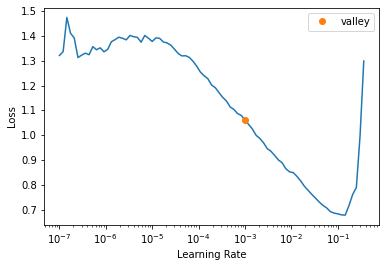

In [ ]:
learner_resnext.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
#เทรนโมเดล 20 รอบ
learner_resnext.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0010000000474974513)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.166362,0.663853,0.238889,0.761111,0.800000,1.000000,0.666667,00:09


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.692923,0.728847,0.322222,0.677778,0.710000,1.000000,0.550388,00:13
1,0.729486,0.516053,0.238889,0.761111,0.801843,0.988636,0.674419,00:12
2,0.663973,0.404764,0.155556,0.844444,0.880342,0.980952,0.798450,00:12
3,0.644180,0.414684,0.155556,0.844444,0.880342,0.980952,0.798450,00:12
4,0.604007,0.473332,0.183333,0.816667,0.854626,0.989796,0.751938,00:12
5,0.564907,0.478820,0.172222,0.827778,0.864629,0.990000,0.767442,00:12
6,0.539679,0.470346,0.150000,0.850000,0.887029,0.963636,0.821705,00:11
7,0.519718,0.481079,0.138889,0.861111,0.897119,0.956140,0.844961,00:12
8,0.483951,0.463147,0.111111,0.888889,0.918699,0.965812,0.875969,00:12
9,0.451578,0.480163,0.094444,0.905556,0.930612,0.982759,0.883721,00:12


In [ ]:
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_back_front

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model3


In [ ]:
learner_resnext.export("resnext50_fastai.pkl")

## densenet201

In [ ]:
learner_Den = vision_learner(dls, models.densenet201, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [ ]:
learner_Den.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
learner_Den.fine_tune(20,  freeze_epochs=1, base_lr =0.0003981071640737355)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.216080,0.798570,0.422222,0.577778,0.634615,0.835443,0.511628,00:34


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.106429,0.601843,0.305556,0.694444,0.761905,0.862745,0.682171,00:11
1,0.987916,0.524993,0.233333,0.766667,0.818966,0.922330,0.736434,00:11
2,0.942775,0.443165,0.172222,0.827778,0.871369,0.937500,0.813953,00:11
3,0.848445,0.395944,0.144444,0.855556,0.890756,0.972477,0.821705,00:11
4,0.771618,0.354730,0.127778,0.872222,0.905350,0.964912,0.852713,00:11
5,0.718879,0.348943,0.127778,0.872222,0.904564,0.973214,0.844961,00:11
6,0.679480,0.356605,0.122222,0.877778,0.909836,0.965217,0.860465,00:11
7,0.623206,0.339040,0.105556,0.894444,0.923077,0.966102,0.883721,00:11
8,0.579308,0.344563,0.105556,0.894444,0.923077,0.966102,0.883721,00:11
9,0.544874,0.351000,0.100000,0.900000,0.927419,0.966387,0.891473,00:11


In [ ]:
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_back_front

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_back_front


In [ ]:
learner_Den.export("densenet201_fastai.pkl")

## VGG19

In [ ]:
learner_VGG19 = cnn_learner(dls, models.vgg19_bn, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0014454397605732083)

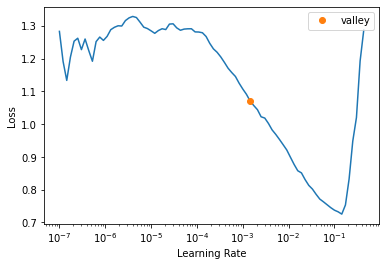

In [ ]:
learner_VGG19.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
learner_VGG19.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0014454397605732083)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.306861,0.744533,0.454545,0.545455,0.655172,0.570000,0.770270,00:10


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.029403,0.685073,0.386364,0.613636,0.679245,0.635294,0.729730,00:13
1,0.931361,0.653031,0.356061,0.643939,0.661871,0.707692,0.621622,00:13
2,0.848119,0.609338,0.310606,0.689394,0.700730,0.761905,0.648649,00:13
3,0.808401,0.535285,0.234848,0.765152,0.783217,0.811594,0.756757,00:13
4,0.757450,0.489019,0.189394,0.810606,0.829932,0.835616,0.824324,00:13
5,0.721366,0.461313,0.174242,0.825758,0.839161,0.869565,0.810811,00:13
6,0.649567,0.456202,0.181818,0.818182,0.828571,0.878788,0.783784,00:13
7,0.592703,0.479727,0.174242,0.825758,0.834532,0.892308,0.783784,00:13
8,0.550041,0.491508,0.181818,0.818182,0.826087,0.890625,0.770270,00:14
9,0.514077,0.520159,0.174242,0.825758,0.832117,0.904762,0.770270,00:13


In [ ]:
learner_VGG19.export("VGG19_fastai.pkl")

## alexnet

In [ ]:
learner_Alex = cnn_learner(dls, alexnet, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

SuggestedLRs(valley=0.001737800776027143)

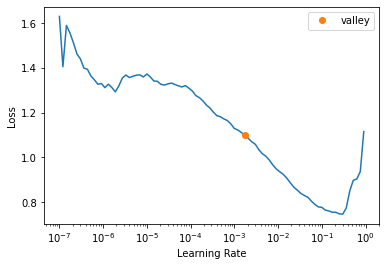

In [ ]:
learner_Alex.lr_find()

In [ ]:
learner_Alex.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.001737800776027143)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.119610,2.421805,0.666667,0.333333,0.130435,1.000000,0.069767,00:05


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.753387,1.188171,0.477778,0.522222,0.505747,0.977778,0.341085,00:06
1,0.693655,0.780572,0.316667,0.683333,0.719212,0.986486,0.565891,00:05
2,0.678775,0.576201,0.211111,0.788889,0.830357,0.978947,0.720930,00:06
3,0.651431,0.488577,0.155556,0.844444,0.880342,0.980952,0.798450,00:05
4,0.620362,0.497182,0.127778,0.872222,0.903766,0.981818,0.837209,00:06
5,0.572253,0.470786,0.105556,0.894444,0.921811,0.982456,0.868217,00:05
6,0.547991,0.469601,0.116667,0.883333,0.914980,0.957627,0.875969,00:05
7,0.517260,0.479687,0.105556,0.894444,0.922449,0.974138,0.875969,00:06
8,0.485444,0.477113,0.088889,0.911111,0.935484,0.974790,0.899225,00:06
9,0.449876,0.445412,0.088889,0.911111,0.937008,0.952000,0.922481,00:06


In [ ]:
learner_Alex.export("alex_fastai.pkl")

# **โหลดโมเดลเพื่อทำนายผล**

## โหลดโมเดลจากที่เซฟไว้

In [ ]:
from fastbook import *
from glob import glob
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

learn_inf = load_learner('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_back_front/VGG16_fastai.pkl')

In [ ]:
test_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(valid_name='test'), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label
    item_tfms=Resize(224,224)
    )

In [ ]:
PathTest = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/img2"
test_dls = test_dblock.dataloaders(PathTest, bs=64)

## สร้าง confusion matix

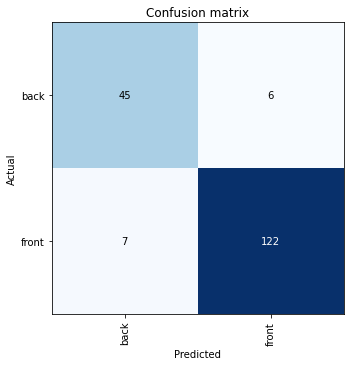

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_inf, dl=dls[1])
interp.plot_confusion_matrix(figsize=(5,5))

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

        back       0.87      0.88      0.87        51
       front       0.95      0.95      0.95       129

    accuracy                           0.93       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.93      0.93      0.93       180



In [ ]:
interp.most_confused(min_val=5)

[('front', 'back', 7), ('back', 'front', 6)]

In [ ]:
learn_inf_.show_results(shuffle=True)